In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray
import matplotlib
import matplotlib.pyplot as plt
from rasterio.enums import Resampling
from carbonplan_forest_risks import load, setup, plot, fit, utils, prepare, collect
from carbonplan.data import cat
from carbonplan_styles.mpl import get_colormap

In [3]:
def load_bill(url):
    target = cat.nlcd.raster.to_dask()
    source = xr.open_rasterio(url)
    source = source.where(source > -1)
    ds = source.rio.reproject_match(target, resampling=Resampling.bilinear)
    ds = (
        ds.where(ds > -1)
        .sel(band=1)
    )

    return ds

In [4]:
base_url_tempate = (
    "https://carbonplan.blob.core.windows.net/carbonplan-scratch/from-bill-05-03-2021/Fig1_4-22-21/{}"
)
dataset_urls = {
    "Insects": {
        "modeled": base_url_tempate.format(
            "Fig1F_InsectModel_ModeledFIAlongEnsembleHistMort_04-22-2021.tif"
        ),
        "observed": base_url_tempate.format(
            "Fig1E_InsectModel_FIAwide-ObsMort_05-08-2021.tif"
        ),
        "reference": 'SuppFig_Williamsetal2016_BarkBeetleOccurrenceMap_04-19-2021.tif'
    },
}

In [5]:
ds_dict = {}
ds_dict['modeled'] = load_bill(dataset_urls['Insects']['modeled']) * 100
ds_dict['observed'] = load_bill(dataset_urls['Insects']['observed']) * 100
ds_dict['reference'] = load_bill(dataset_urls['Insects']['reference'])

/srv/conda/envs/notebook/lib/python3.8/site-packages/rioxarray/raster_array.py:126: UserWarning: The nodata value (-3.4e+38) has been automatically changed to (-3.3999999521443642e+38) to match the dtype of the data.
  warnings.warn(


In [6]:
plot_params = {
    "modeled": {
        "cmap": get_colormap("blues"),
        "var_lims": (0, 0.4),
        "label": "Insect-related\nmortality (%/year)",
        "panel": ["E", "F"],
        "cbar_ylocation": 0.76,
    },
     "observed": {
        "cmap": get_colormap("blues"),
        "var_lims": (0, 0.4),
        "label": "Insect-related\nmortality (%/year)",
        "panel": ["E", "F"],
        "cbar_ylocation": 0.4,
    },
    "reference": {
        "cmap": get_colormap("blues"),
        "var_lims": (0, 0.5),
        "label": "Area affected\n(% grid cell/year)",
        "panel": ["E", "F"],
        "cbar_ylocation": 0.04,
    },
}

In [7]:
matplotlib.rc("font", family="sans-serif")
matplotlib.rc("font", serif="Helvetica Neue")
matplotlib.rc("text", usetex="false")
matplotlib.rcParams.update({"font.size": 14, "svg.fonttype": "none"})

<ipython-input-8-ccb864c684e9>:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=-6)


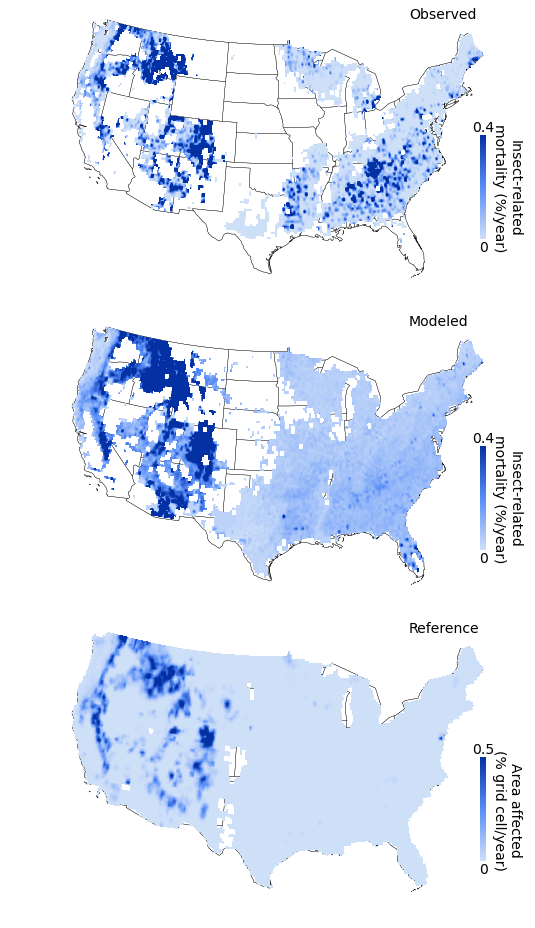

In [8]:
fig, axarr = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(5, 12),
    subplot_kw={"projection": plot.cartopy_proj_albers()},
)
for row, setup in enumerate(["observed", "modeled", "reference"]):
    vmin, vmax = (
        plot_params[setup]["var_lims"][0],
        plot_params[setup]["var_lims"][1],
    )
    map_plot = ds_dict["{}".format(setup)].plot.imshow(
        ax=axarr[row],
        cmap=plot_params[setup]["cmap"],
        vmin=vmin,
        vmax=vmax,
        add_colorbar=False,
        add_labels=False
    )
    plot.map_pretty(axarr[row], title=setup.capitalize())
    plot.add_colorbar(
        fig,
        to_plot=map_plot,
        y_location=plot_params[setup]["cbar_ylocation"],
        vmin=plot_params[setup]["var_lims"][0],
        vmax=plot_params[setup]["var_lims"][1],
        cbar_label=plot_params[setup]["label"],
    )
plt.tight_layout(pad=-6)
fig.savefig("Supplementary-Figure-2.svg", format="svg", bbox_inches="tight")